# Simulation Tools - Project 1

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import assimulo.problem as apro
import assimulo.solvers as asol


Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


---------------------------------------------------------------------

## Task 1

#### Define pendulum function

In [2]:
def elastic_pendulum(t: float=0.0, x: np.ndarray=np.array([0.0, 0.0, 0.0, 0.0]), k: float=1.0) -> np.ndarray:
    lmb = lambda y1, y2: (lambda d: k*(d - 1)/d if d != 0 else 0)(np.sqrt(y1**2 + y2**2))    # avoid division by zero -- just in case

    xvec = np.zeros_like(x)
    xvec[0] = x[2]
    xvec[1] = x[3]
    xvec[2] = -x[0] * lmb(x[0], x[1])
    xvec[3] = -x[1] * lmb(x[0], x[1]) - 1
    return xvec


#### Setup values

In [3]:
k = 1.0
t0, tfinal = 0.0, 10.0
y0 = np.array([1.0, 0.0, 0.0, 1.5])


#### Wrap as an Assimulo Explicit Problem

In [4]:
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=k), t0=t0, y0=y0)
spring_problem.name = r'Spring Pendulum with spring constant k={k}'
spring_problem.name = spring_problem.name.format(k=k)


#### CVode solver

In [6]:
spring_solver = asol.CVode(spring_problem)
spring_solver.reset()
# spring_solver.rtol = 1e-4
# spring_solver.atol = 1e-4
# spring_solver.discr = 'ADAMS'
# spring_solver.maxord = 8
t_sol, x_sol = spring_solver.simulate(100, 1000)


Final Run Statistics: Spring Pendulum with spring constant k=1.0 

 Number of steps                                 : 1444
 Number of function evaluations                  : 1786
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 100
 Number of error test failures                   : 69
 Number of nonlinear iterations                  : 1783
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.00693975500007582 seconds.


#### Plot the results

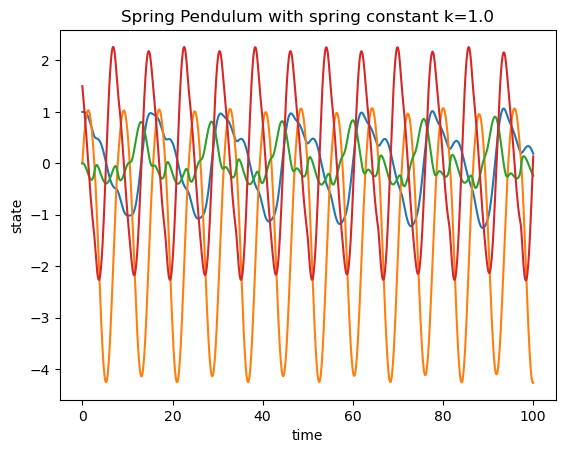

In [7]:
spring_solver.plot()


-------------------------------------------------------------------

## Task 2

#### Implement BDF4 solver using BDF2 template

In [47]:
from assimulo.explicit_ode import Explicit_ODE
from assimulo.ode import *
import scipy.linalg as SL


In [ ]:
class BDF_4(Explicit_ODE):
    """
    BDF-4   (Example of how to set-up own integrators for Assimulo)
    """
    tol=1.e-8     
    maxit=100     
    maxsteps=50000
    
    ALPHA_BDF2 = [3/2,  -2.0,   1/2]
    ALPHA_BDF3 = [11/6, -3.0,   3/2,  -1/3]
    ALPHA_BDF4 = [25/12, -4.0,  3.0,  -4/3, 1/4]

    def __init__(self, problem, nonlin_solver='Newton'):
        self.nonlin_solver = nonlin_solver
        Explicit_ODE.__init__(self, problem) # Calls the base class
        
        #Solver options
        self.options["h"] = 0.01
        
        #Statistics
        self.statistics["nsteps"] = 0
        self.statistics["nfcns"] = 0

        self.init_methods = []
    
    def _set_h(self,h):
            self.options["h"] = float(h)

    def _get_h(self):
        return self.options["h"]
        
    h=property(_get_h,_set_h)
        
    def integrate(self, t, y, tf, opts):
        h = min(self.h, abs(tf - t))

        tres = [t]
        yres = [y.copy()]

        for i in range(self.maxsteps):
            if tres[-1] >= tf:
                break

            self.statistics["nsteps"] += 1
            h = min(self.h, abs(tf - tres[-1]))

            if len(yres) == 1:
                t_np1, y_np1 = self.step_EE(tres[0], yres[0], h)
                self.init_methods.append('EE')
            elif len(yres) == 2:
                t_np1, y_np1 = self.step_BDFk_fp(self.ALPHA_BDF2, tres, yres, h)
                self.init_methods.append('BDF2')
            elif len(yres) == 3:
                t_np1, y_np1 = self.step_BDFk_fp(self.ALPHA_BDF3, tres, yres, h)
                self.init_methods.append('BDF3')
            else:
                t_np1, y_np1 = self.step_BDFk_fp(self.ALPHA_BDF4, tres, yres, h)

            tres.append(t_np1)
            yres.append(y_np1.copy())

        else:
            raise Explicit_ODE_Exception("Final time not reached within maximum number of steps")

        return ID_PY_OK, tres, yres
    
    def step_EE(self, t, y, h):
        """
        This calculates the next step in the integration with explicit Euler.
        """
        self.statistics["nfcns"] += 1
        
        f = self.problem.rhs
        return t + h, y + h*f(t, y) 
        
    def step_BDFk_fp(self, alpha, t, y, h):
        """
        This calculates the next step in the integration with BDF of order k using fixed-point iteration.
        """
        f = self.problem.rhs

        t_n = t[-1]
        t_np1 = t_n + h

        k = len(alpha) - 1 # order of BDF
        if len(y) < k: 
            raise Explicit_ODE_Exception(f"Not enough history for BDF{k}")


        total = 0.0    # Collecting all terms of BDF
        for j in range(1, k + 1):
            total += alpha[j] * y[-j]
        y_i = y[-1].copy()    # initial point for nonlinear solver (solution at previous time step)

        for it in range(self.maxit):
            if self.nonlin_solver == 'FixedPoint':
                self.statistics["nfcns"] += 1
                y_ip1 = (-total + h * f(t_np1, y_i)) / alpha[0]
                if SL.norm(y_ip1 - y_i) < self.tol:
                    return t_np1, y_ip1
                
            elif self.nonlin_solver == 'Newton':
                    g = alpha[0]*y_i + total - h*f(t_np1, y_i)
                    self.statistics["nfcns"] += 1

                    J = np.zeros((y_i.size, y_i.size))
                    eps = np.sqrt(np.finfo(float).eps)

                    for j in range(y_i.size):
                        dz = eps*(1 + abs(y_i[j]))

                        zp = y_i.copy()
                        zm = y_i.copy()
                        zp[j] += dz
                        zm[j] -= dz

                        gp = alpha[0]*zp + total - h*f(t_np1, zp)
                        gm = alpha[0]*zm + total - h*f(t_np1, zm)

                        self.statistics["nfcns"] += 2

                        J[:, j] = (gp - gm) / (2*dz)

                    delta = SL.solve(J, -g)
                    y_new = y_i + delta

                    if SL.norm(delta) < self.tol*(1 + SL.norm(y_new)):
                        return t_np1, y_new

                    y_i = y_new

            else:
                raise Explicit_ODE_Exception(f"Unknown nonlinear solver: {self.nonlin_solver}")

        raise Explicit_ODE_Exception(f"BDF{k} corrector did not converge in {self.maxit} iterations")


            
    def print_statistics(self, verbose=NORMAL):
        self.log_message('Final Run Statistics            : {name} \n'.format(name=self.problem.name),        verbose)
        self.log_message(' Step-length                    : {stepsize} '.format(stepsize=self.options["h"]), verbose)
        self.log_message(' Number of Steps                : '+str(self.statistics["nsteps"]),          verbose)               
        self.log_message(' Number of Function Evaluations : '+str(self.statistics["nfcns"]),         verbose)
            
        self.log_message('\nSolver options:\n',                                    verbose)
        self.log_message(' Solver            : BDF4',                     verbose)
        self.log_message(f' Solver type       : {self.nonlin_solver}\n',                      verbose)
        self.log_message('Initialization methods used : ' + ', '.join(self.init_methods), verbose)


Final Run Statistics            : Spring Pendulum with spring constant k=1.0 

 Step-length                    : 0.01 
 Number of Steps                : 10000
 Number of Function Evaluations : 239158

Solver options:

 Solver            : BDF4
 Solver type       : Newton

Initialization methods used : EE, BDF2, BDF3
Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 2.2029421589995763 seconds.


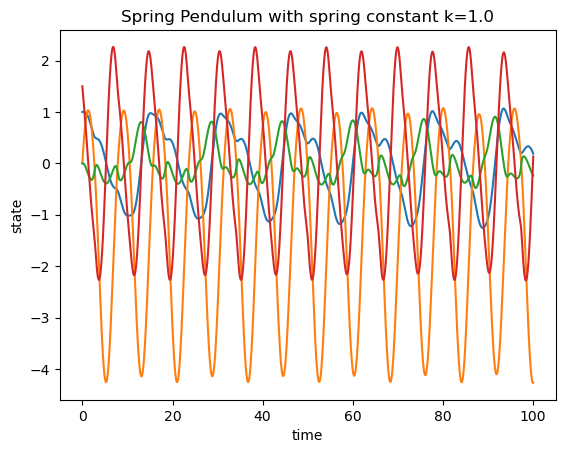

In [89]:
#Define an Assimulo problem
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=k), t0=t0, y0=y0)
spring_problem.name = r'Spring Pendulum with spring constant k={k}'
spring_problem.name = spring_problem.name.format(k=k)

#Define an explicit solver
test_sim = BDF_4(spring_problem, nonlin_solver='Newton') #Create a BDF solver
t, y = test_sim.simulate(100)
test_sim.plot()
plt.show()
